In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [ ]:
!pip install livelossplot
!pip install pytorch_forecasting
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_exte

In [ ]:


import os
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np

import math

import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler

from livelossplot import PlotLosses

from itertools import chain

import sklearn.metrics
import time
import joblib

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


In [ ]:


import warnings
warnings.filterwarnings('ignore')

In [ ]:
class HotelDataset(Dataset):
  def __init__(self, split='train'):
    """
    1. Load the data, e.g. df= pd.Feather load ()

    Data preprocessing:
    - Make sure fast indexing, so, maybe use guest_id as index
    - New time index, running from 1 (first time) ... last_time
    - Data needs to be all numerical, use encoders to encode data if needed before hand
    - Normalize data
    """
    self.scaled_df = pd.read_csv('output/10_selected_guest_data/df_original_data_standardscaler', index_col = [0,1])
    self.scaled_df = self.scaled_df.drop(["amount_times_visited", "weekday_arrival_date", "weekday_creation_date"], axis = 1)
    self.scaled_df.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.scaled_df.index])
    self.scaled_df = self.scaled_df.iloc[1:, :]
    missing_rows = self.scaled_df.isnull().any(axis = 1)
    self.scaled_df = self.scaled_df[~missing_rows]
    guests = self.scaled_df.index.get_level_values(0)
    self.guest_idx = np.unique([guests[0]] + list(guests[1:].astype(str)))
    self.split_indexes = self.train_test_split(split)
    self.y = pd.read_csv('output/10_selected_guest_data/y_original_data', index_col = [0,1])
    self.y.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.y.index])
    self.y = self.y[~missing_rows.values]
    return

  def train_test_split(self, split):
    np.random.seed(42)
    max_guests = len(self.guest_idx)
    n = int(max_guests * 0.8)

    indexes = np.random.permutation(max_guests)

    if split == "train":
      return indexes[:n]
    elif split == "validation":
      return indexes[n:]

  def __len__(self):
    """
    np.unique(guests)
    """
    return len(self.split_indexes)

  def __getitem__(self, idx):
    """
    idx --> guest_id
    self.df[idx]
    """

    idx = self.split_indexes[idx]
    chosen_guest = self.scaled_df.loc[self.guest_idx[idx]]
    y_guest = self.y.loc[self.guest_idx[idx]]
    y_array = y_guest.to_numpy().squeeze(1)
    columns_guest = chosen_guest.columns
    guest_array = chosen_guest.to_numpy()  # [sequence length, columns]

    cut_off = np.random.randint(1, guest_array.shape[0]) if guest_array.shape[0] > 1 else 1
    return torch.Tensor(guest_array[:cut_off, :]), y_array[cut_off -1]


In [ ]:
class RNNPosEncoder(nn.Module):
  def __init__(self, rnn_input_size, rnn_hidden_dim, n_layers_rnn):
    super(RNNPosEncoder, self).__init__()
    self.lstm = nn.LSTM(input_size=rnn_input_size, hidden_size=rnn_hidden_dim,
                        num_layers=n_layers_rnn, batch_first=True)

  def forward(self, x):
    out, (_, _) = self.lstm(x)
    return out

In [ ]:
class SelfAttentionNet(nn.Module):
  def __init__(self, nhead, n_features_in, n_features_attention_heads,
               num_layers, positional_encoder, activation = nn.ReLU, dropout=0, device='cpu'):
    super(SelfAttentionNet, self).__init__()

    self.booking_embedding = nn.Sequential(
            nn.Linear(n_features_in, 64),
            activation(),
            nn.Linear(64, 64),
            # activation()
        )

    self.positional_encoder = positional_encoder

    self.encoder_layer = nn.TransformerEncoderLayer(
        d_model=n_features_attention_heads, nhead=nhead, dropout=dropout)
    self.transformer_encoder = nn.TransformerEncoder(
        self.encoder_layer, num_layers=num_layers)

    self.device=device

    self.regression_head = nn.Linear(n_features_attention_heads, 1)

  def forward(self, x, seq_length):
    embedded = self.booking_embedding(x)

    pos_encoding = self.positional_encoder(embedded)

    padding_mask = torch.arange(x.shape[1], device=self.device).repeat(x.shape[0], 1) >= seq_length.unsqueeze(1)

    padding_mask_swapped = padding_mask.swapaxes(0,1)

    transformer_out = self.transformer_encoder(pos_encoding, src_key_padding_mask=padding_mask_swapped)



    output = self.regression_head(transformer_out)
    last_output = output[:, -1]
    return last_output.squeeze(1)



In [ ]:
!pip install torch-summary
from torchsummary import summary

In [ ]:
class NextEventNoStopLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.mse = nn.MSELoss(reduction='none')

  def forward(self, y_target, y_pred):
    mse_loss = self.mse(y_pred, y_target)
    mse_filtered = torch.mean(mse_loss[y_target != -1000])
    return mse_filtered


In [ ]:
def pad_batch(batch):
  booking_seqs, labels = zip(*batch)
  seq_length = [len(booking) for booking in booking_seqs]
  padded_booking_seqs = pad_sequence(booking_seqs, batch_first=True, padding_value=-10)
  return padded_booking_seqs, torch.Tensor(labels), seq_length

In [ ]:
data_train = HotelDataset(split='train')
data_test = HotelDataset(split='validation')



<ipython-input-5-0bf63c4f3685>:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.scaled_df = pd.read_csv('output/10_selected_guest_data/df_original_data_standardscaler', index_col = [0,1])
<ipython-input-5-0bf63c4f3685>:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.scaled_df = pd.read_csv('output/10_selected_guest_data/df_original_data_standardscaler', index_col = [0,1])


In [ ]:
pos_encoder = RNNPosEncoder(rnn_input_size=64, rnn_hidden_dim=64, n_layers_rnn=2)
attention_model = SelfAttentionNet(nhead=8, n_features_in=21,
                                   n_features_attention_heads=64,
                                   num_layers=16,
                                   positional_encoder=pos_encoder, device='cuda')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
train_loader = DataLoader(data_train, batch_size=128, collate_fn=pad_batch)
valid_loader = DataLoader(data_test, batch_size=128, collate_fn = pad_batch)

optimizer = Adam(attention_model.parameters())
loss_fn = NextEventNoStopLoss()
num_epochs = 20

In [ ]:
summary(attention_model)

Layer (type:depth-idx)                                  Param #
├─Sequential: 1-1                                       --
|    └─Linear: 2-1                                      1,408
|    └─ReLU: 2-2                                        --
|    └─Linear: 2-3                                      4,160
├─RNNPosEncoder: 1-2                                    --
|    └─LSTM: 2-4                                        66,560
├─TransformerEncoderLayer: 1-3                          --
|    └─MultiheadAttention: 2-5                          --
|    |    └─NonDynamicallyQuantizableLinear: 3-1        4,160
|    └─Linear: 2-6                                      133,120
|    └─Dropout: 2-7                                     --
|    └─Linear: 2-8                                      131,136
|    └─LayerNorm: 2-9                                   128
|    └─LayerNorm: 2-10                                  128
|    └─Dropout: 2-11                                    --
|    └─Dropout: 2-12      

Layer (type:depth-idx)                                  Param #
├─Sequential: 1-1                                       --
|    └─Linear: 2-1                                      1,408
|    └─ReLU: 2-2                                        --
|    └─Linear: 2-3                                      4,160
├─RNNPosEncoder: 1-2                                    --
|    └─LSTM: 2-4                                        66,560
├─TransformerEncoderLayer: 1-3                          --
|    └─MultiheadAttention: 2-5                          --
|    |    └─NonDynamicallyQuantizableLinear: 3-1        4,160
|    └─Linear: 2-6                                      133,120
|    └─Dropout: 2-7                                     --
|    └─Linear: 2-8                                      131,136
|    └─LayerNorm: 2-9                                   128
|    └─LayerNorm: 2-10                                  128
|    └─Dropout: 2-11                                    --
|    └─Dropout: 2-12      

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def train_no_stop(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, device = "cuda"):
  liveloss = PlotLosses()
  model.to(device)
  for epoch in range(num_epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    epoch_loss_train = 0.0
    for i,data in enumerate(train_loader):#, 0)
      inputs, labels, seq_length = data
      seq_length = torch.Tensor(seq_length)
      inputs, labels, seq_length = inputs.to(device), labels.to(device), seq_length.to(device)
      optimizer.zero_grad()
      next_event_pred = model(inputs, seq_length)
      loss = loss_fn(labels, next_event_pred)

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      epoch_loss_train += loss.item()

      if i % 200 == 199:    # print every 2000 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (200*32):.3f}')
          running_loss = 0.0

    logs['train_loss value'] = epoch_loss_train / len(train_loader.dataset)

    model.eval()
    with torch.no_grad():
      valid_loss = 0.0

      for i,data in enumerate(valid_loader):#, 0)
        inputs, labels, seq_length = data
        seq_length = torch.Tensor(seq_length)
        inputs, labels, seq_length = inputs.to(device), labels.to(device), seq_length.to(device)
        next_event_pred = model(inputs, seq_length)
        loss = loss_fn(labels, next_event_pred)
        valid_loss += loss.item()
    logs['valid_loss value'] = valid_loss / len(valid_loader.dataset)
    print(logs)
    liveloss.update(logs)
    liveloss.send()

In [ ]:
def predict_no_stop(model, valid_loader, device = "cuda"):
  model.to(device)
  model.eval()
  next_event_pred_list = []
  labels_list = []
  with torch.no_grad():

    for i,data in enumerate(valid_loader):#, 0)
      inputs, labels, seq_length = data
      seq_length = torch.Tensor(seq_length)
      inputs, labels, seq_length = inputs.to(device), labels.to(device), seq_length.to(device)
      # print(labels)
      next_event_pred = model(inputs, seq_length)

      next_event_pred_list.extend(next_event_pred.cpu().tolist())
      labels_list.extend(labels.cpu().tolist())
    labels_list = pd.Series(labels_list)
    next_event_pred_list = pd.Series(next_event_pred_list)
    mask = labels_list != -1000
    labels_list = labels_list[mask]
    next_event_pred_list = next_event_pred_list[(mask).values]

  return next_event_pred_list, labels_list

In [ ]:
import torch
torch.cuda.empty_cache()

to run ten times

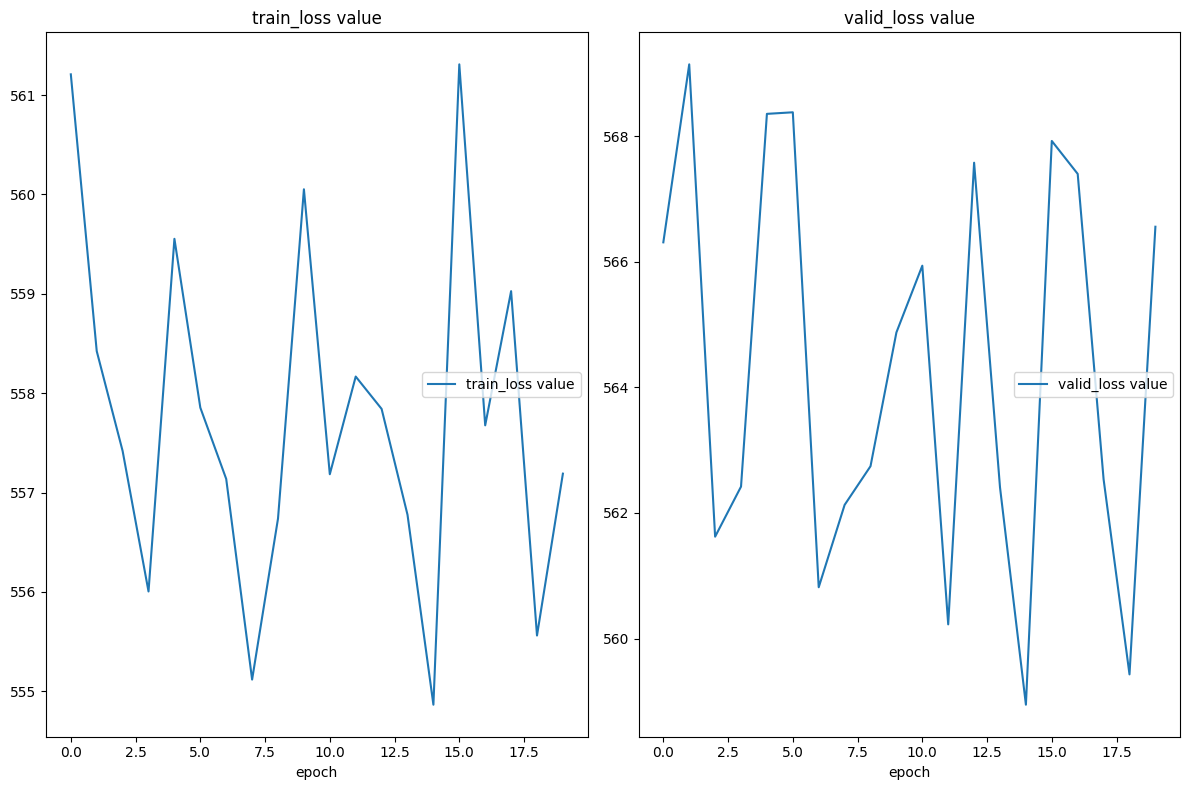

train_loss value
	train_loss value 	 (min:  554.864, max:  561.310, cur:  557.190)
valid_loss value
	valid_loss value 	 (min:  558.947, max:  569.143, cur:  566.557)
rmse: 266.2908641650331
mae: 208.7517573590411


In [ ]:
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
for i in range(10):
  start_time = time.time()
  train_no_stop(attention_model, train_loader, valid_loader, optimizer, loss_fn, num_epochs)
  t = time.time() - start_time
  t = round(t)
  joblib.dump(attention_model, "Trained_models/transformerencoder_model_finaloriginal_{0}_{1}.pkl".format(i, t))
  stop_pred_old, labels_old = predict_no_stop(attention_model, valid_loader)
  labels_old = labels_old.reset_index()
  labels_old = labels_old.drop(["index"], axis = 1)
  df_old = pd.concat([labels_old, stop_pred_old], axis = 1)
  df_old.columns = ["labels", "next_event"]
  df_sorted = df_old.copy()
  rmse = np.sqrt(mean_squared_error(df_sorted["labels"], df_sorted["next_event"]))
  mae = mean_absolute_error(df_sorted["labels"], df_sorted["next_event"])
  print(f"rmse: {rmse}")
  print(f"mae: {mae}")
  df_sorted["labels_label"] = 0
  df_sorted["next_event_label"] = 0
  for i in range(len(df_sorted)):
    if df_sorted["labels"][i] < 15:
      df_sorted["labels_label"][i] = 1
    elif 15 < df_sorted["labels"][i] < 61:
      df_sorted["labels_label"][i] = 2
    elif 61 < df_sorted["labels"][i] < 180:
      df_sorted["labels_label"][i] = 3
    else:
      df_sorted["labels_label"][i] = 4
    if df_sorted["next_event"][i] < 15:
      df_sorted["next_event_label"][i] = 1
    elif 16 < df_sorted["next_event"][i] < 61:
      df_sorted["next_event_label"][i] = 2
    elif 61 < df_sorted["next_event"][i] < 180:
      df_sorted["next_event_label"][i] = 3
    else:
      df_sorted["next_event_label"][i] = 4
  precision_score = sklearn.metrics.precision_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
  recall_score = sklearn.metrics.recall_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
  f1_score = sklearn.metrics.f1_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro")
  rmse_list.append(rmse)
  mae_list.append(mae)
  precision_list.append(precision_score)
  recall_list.append(recall_score)
  f1_list.append(f1_score)
  time_list.append(t)

In [ ]:
np.std(mae_list)

0.9831509481768247

In [ ]:
np.std(rmse_list)

0.9681631093921388

In [ ]:
np.mean(mae_list)

208.96162540092354

In [ ]:
np.mean(rmse_list)

266.97949102426765

In [ ]:
np.mean(precision_list)

0.18347195683938405

In [ ]:
np.mean(recall_list)

0.25

In [ ]:
np.mean(f1_list)

0.2116299361377961

<ipython-input-17-5a4db0336977>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sorted["labels"],hist = True, label ="labels")
<ipython-input-17-5a4db0336977>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sorted["next_event"],hist = True, label ="predicted_labels")


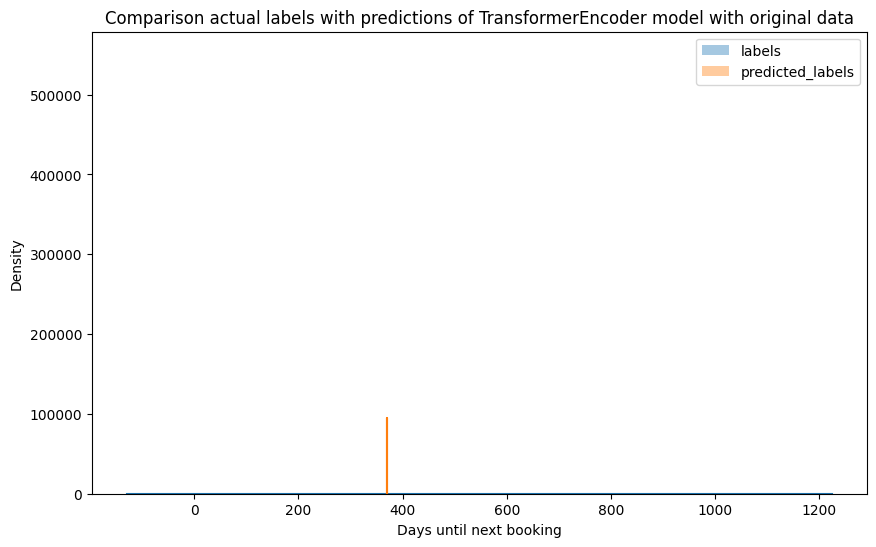

In [ ]:
import seaborn as sns
fig = plt.figure(figsize=(10,6))
sns.distplot(df_sorted["labels"],hist = True, label ="labels")
sns.distplot(df_sorted["next_event"],hist = True, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of TransformerEncoder model with original data")
plt.xlabel("Days until next booking")
plt.legend()

<ipython-input-18-c8278f6defd1>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sorted["labels"] - df_sorted['next_event'],hist = True)


Text(0.5, 0, 'Days until next booking')

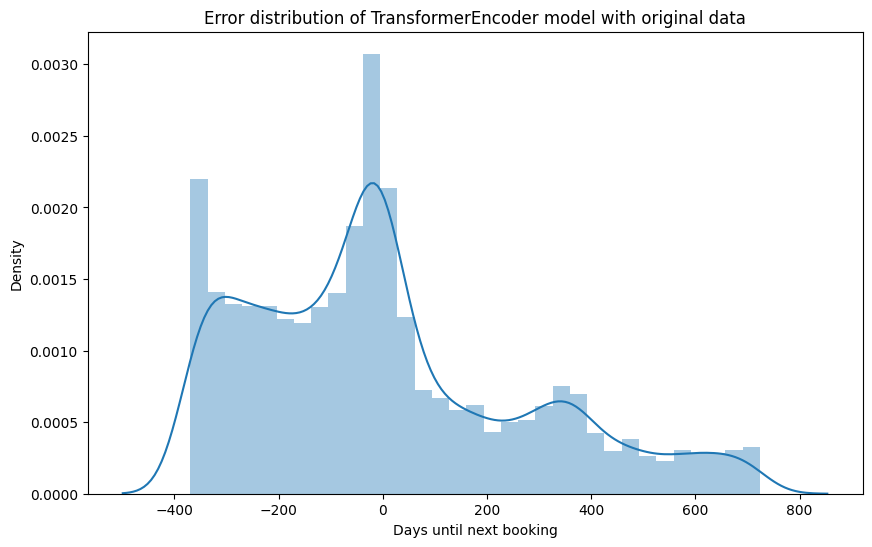

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_sorted["labels"] - df_sorted['next_event'],hist = True)
plt.title("Error distribution of TransformerEncoder model with original data")
plt.xlabel("Days until next booking")

In [ ]:
cm = confusion_matrix(df_sorted["labels_label"], df_sorted["next_event_label"])
cm_df = pd.DataFrame(cm, index = [1, 2, 3, 4], columns = [1,2,3,4])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True)
plt.title("Confusion Matrix original data TransformerEncoder")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()